In [1]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas matplotlib statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/appl-data/Apple Inc. Common Stock.csv
/kaggle/input/historicaldata/HistoricalData_AAPL  Historical Quotes.csv


Data preparation

In [4]:
import pandas as pd

# Load the data
appdata = pd.read_csv("/kaggle/input/historicaldata/HistoricalData_AAPL  Historical Quotes.csv")

print(appdata)




            Date Close/Last     Volume      Open      High        Low
0     12/26/2024    $259.02   27262980   $258.19   $260.10    $257.63
1     12/24/2024    $258.20   23234710   $255.49   $258.21    $255.29
2     12/23/2024    $255.27   40858770   $254.77   $255.65    $253.45
3     12/20/2024    $254.49  147495300   $248.04   $255.00    $245.69
4     12/19/2024    $249.79   60882260   $247.50   $252.00  $247.0949
...          ...        ...        ...       ...       ...        ...
1253  01/03/2020   $74.3575  146535520  $74.2875   $75.145    $74.125
1254  01/02/2020   $75.0875  135647440    $74.06    $75.15   $73.7975
1255  12/31/2019   $73.4125  100990520  $72.4825    $73.42     $72.38
1256  12/30/2019     $72.88  144238440   $72.365  $73.1725    $71.305
1257  12/27/2019     $72.45  146371760    $72.78  $73.4925     $72.03

[1258 rows x 6 columns]


In [5]:

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
# 1. Load and prepare your data (replace with your file path)
try:
    appdata = pd.read_csv("/kaggle/input/historicaldata/HistoricalData_AAPL  Historical Quotes.csv")
except FileNotFoundError:
    print("Error: 'HistoricalData_COOP Historical Quotes.csv' not found. Please provide the correct path.")
    exit()
    
appdata['Date'] = pd.to_datetime(appdata['Date'])
appdata = appdata.set_index('Date')
# Cleaning
appdata['Close/Last'] = appdata['Close/Last'].astype(str).str.replace(',', '', regex=False).str.replace('$', '', regex=False).str.replace('%', '', regex=False).str.replace(' ', '', regex=False).replace('-', pd.NA).replace('null', pd.NA).replace('', pd.NA)

# Convert to numeric
appdata['Close/Last'] = pd.to_numeric(appdata['Close/Last'], errors='coerce')

# Handle missing values
appdata.dropna(subset=['Close/Last'], inplace=True)
#Or
#appdata['Close/Last'].fillna(method='ffill', inplace=True)
#Now you can use the data
monthly_appdatats = appdata['Close/Last']
# ...rest of your code



In [6]:
print(monthly_appdatats)

Date
2024-12-26    259.0200
2024-12-24    258.2000
2024-12-23    255.2700
2024-12-20    254.4900
2024-12-19    249.7900
                ...   
2020-01-03     74.3575
2020-01-02     75.0875
2019-12-31     73.4125
2019-12-30     72.8800
2019-12-27     72.4500
Name: Close/Last, Length: 1258, dtype: float64


In [7]:



# Select the 'Close Price' and ensure it's numeric
try:
    monthly_appdatats = appdata['Close/Last'].astype(float)
except KeyError:
    print("Error: 'Close/Last' column not found. Check your CSV file.")
    exit()
except ValueError:
    print("Error: 'Close/Last' column contains non-numeric values. Clean your data.")
    exit()


# Resample to monthly frequency (important for yearly seasonality)
monthly_appdatats = monthly_appdatats.resample('M').last()

#Remove any NaN values from the timeseries
monthly_appdatats = monthly_appdatats.dropna()

In [8]:
print(pd.options.display.max_rows) 

60


In [9]:
print(monthly_appdatats.head())

Date
2019-12-31    73.4125
2020-01-31    77.3775
2020-02-29    68.3400
2020-03-31    63.5725
2020-04-30    73.4500
Freq: M, Name: Close/Last, dtype: float64


In [10]:
print(monthly_appdatats.tail()) 

Date
2024-08-31    229.00
2024-09-30    233.00
2024-10-31    225.91
2024-11-30    237.33
2024-12-31    259.02
Freq: M, Name: Close/Last, dtype: float64


In [11]:
print(monthly_appdatats.info())

<class 'pandas.core.series.Series'>
DatetimeIndex: 61 entries, 2019-12-31 to 2024-12-31
Freq: M
Series name: Close/Last
Non-Null Count  Dtype  
--------------  -----  
61 non-null     float64
dtypes: float64(1)
memory usage: 976.0 bytes
None


In [12]:
print(monthly_appdatats.duplicated())

Date
2019-12-31    False
2020-01-31    False
2020-02-29    False
2020-03-31    False
2020-04-30    False
              ...  
2024-08-31    False
2024-09-30    False
2024-10-31    False
2024-11-30    False
2024-12-31    False
Freq: M, Name: Close/Last, Length: 61, dtype: bool


In [13]:
# Displaying the cleaned dataset for verification
monthly_appdatats.head(), monthly_appdatats.describe()

(Date
 2019-12-31    73.4125
 2020-01-31    77.3775
 2020-02-29    68.3400
 2020-03-31    63.5725
 2020-04-30    73.4500
 Freq: M, Name: Close/Last, dtype: float64,
 count     61.00000
 mean     154.23291
 std       43.74819
 min       63.57250
 25%      129.93000
 50%      153.34000
 75%      177.57000
 max      259.02000
 Name: Close/Last, dtype: float64)

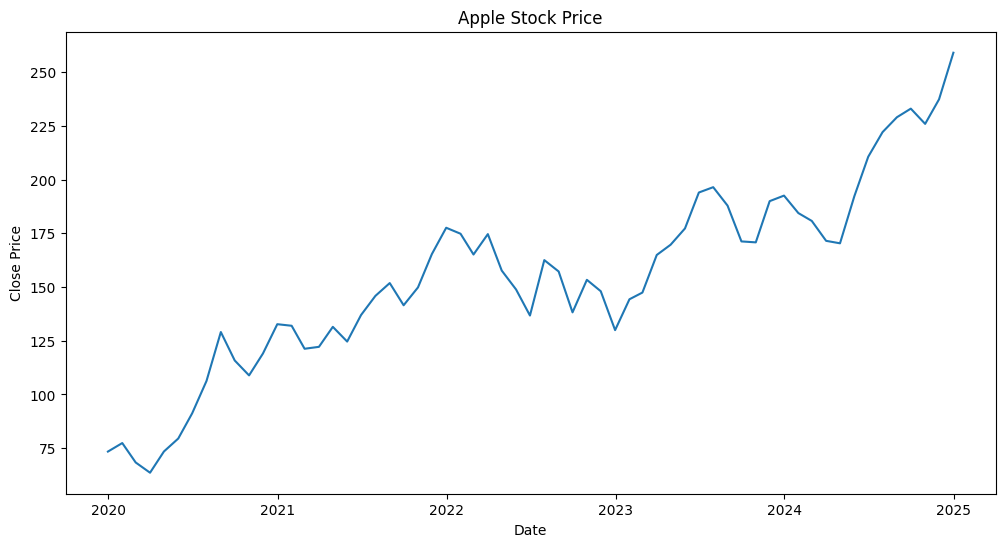

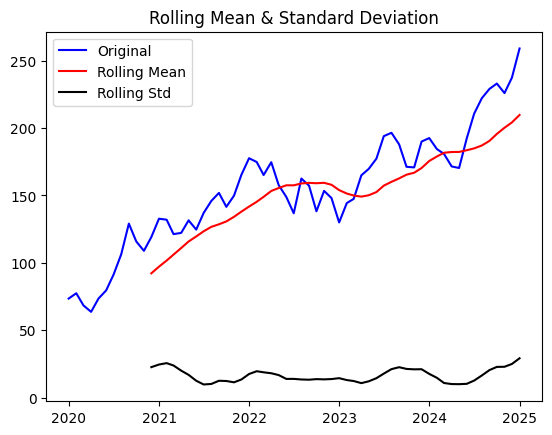

In [14]:
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(monthly_appdatats)
plt.title("Apple Stock Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

# Calculate and plot rolling statistics
rolmean = monthly_appdatats.rolling(window=12).mean()
rolstd = monthly_appdatats.rolling(window=12).std()
plt.plot(monthly_appdatats, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [15]:
# 2. Determine the seasonality period (crucial step!)
# Let's assume yearly seasonality (12 months). Adjust if needed.
period = 12

# 3. Choose the decomposition model (additive or multiplicative)
# Start with additive and check the residual plot later.
model = 'additive'

# 4. Perform the decomposition (with error handling)
try:
    decomposition = seasonal_decompose(monthly_appdatats, model=model, period=period, extrapolate_trend='freq')
except ValueError as e:
    print(f"Decomposition error: {e}. Check your data and period. Ensure your data is long enough for the given period.")
    exit()

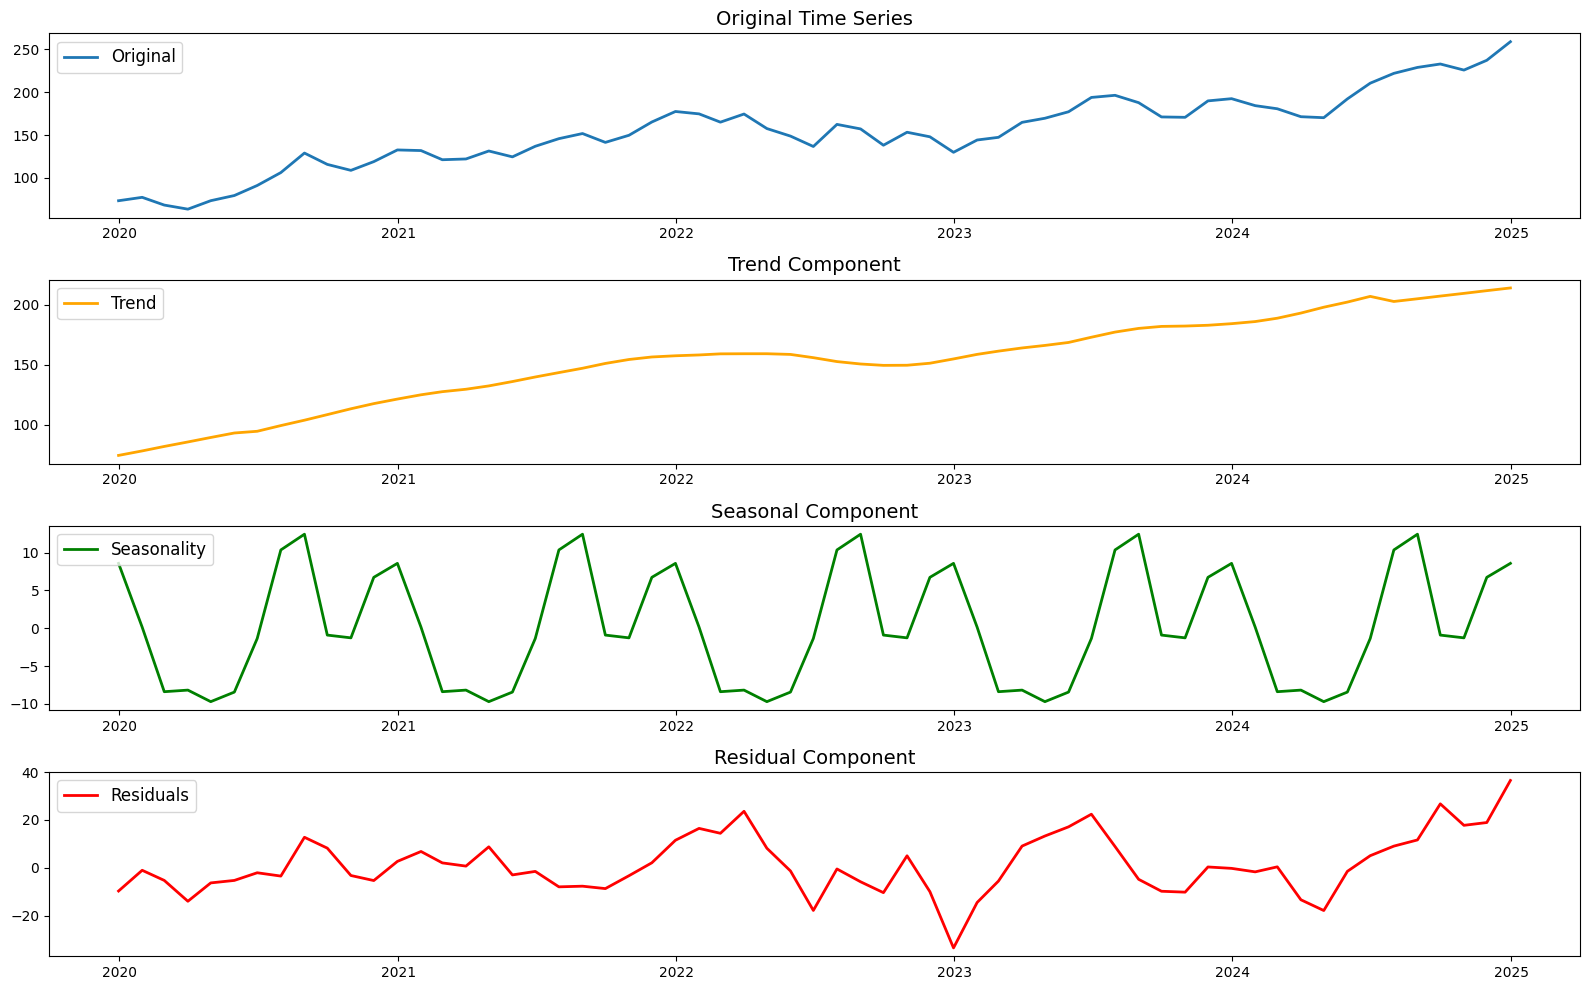

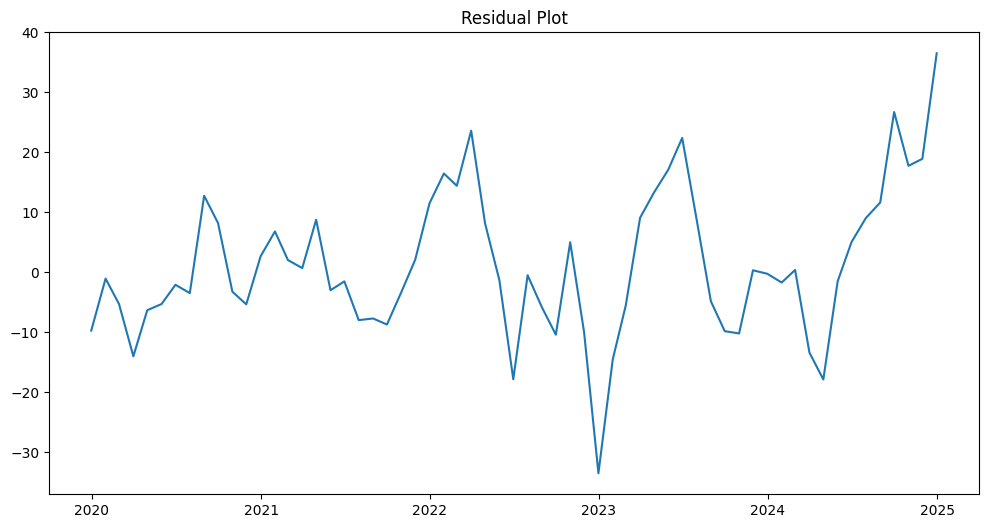


First 10 Trend values:
 Date
2019-12-31     74.540892
2020-01-31     78.271961
2020-02-29     82.003030
2020-03-31     85.734099
2020-04-30     89.465168
2020-05-31     93.196237
2020-06-30     94.624688
2020-07-31     99.368854
2020-08-31    103.848125
2020-09-30    108.493854
Freq: M, Name: trend, dtype: float64

First 10 Seasonality values:
 Date
2019-12-31     8.576133
2020-01-31     0.143755
2020-02-29    -8.386125
2020-03-31    -8.175422
2020-04-30    -9.702136
2020-05-31    -8.436433
2020-06-30    -1.353540
2020-07-31    10.348783
2020-08-31    12.429816
2020-09-30    -0.904525
Freq: M, Name: seasonal, dtype: float64

First 10 Residuals values:
 Date
2019-12-31    -9.704525
2020-01-31    -1.038217
2020-02-29    -5.276905
2020-03-31   -13.986177
2020-04-30    -6.313032
2020-05-31    -5.274804
2020-06-30    -2.071147
2020-07-31    -3.457637
2020-08-31    12.762059
2020-09-30     8.220671
Freq: M, Name: resid, dtype: float64

Mean of Residuals:
 1.2143525806273268


In [16]:
# 5. Handle NaN values (more robust handling)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#Use linear interpolation to fill in any missing values
trend = trend.interpolate(method='linear')
seasonal = seasonal.interpolate(method='linear')
residual = residual.interpolate(method='linear')

# 6. Plot the components with improved formatting
plt.figure(figsize=(16, 10))

plt.subplot(411)
plt.plot(monthly_appdatats, label='Original', linewidth=2)
plt.legend(loc='upper left', fontsize=12)
plt.title('Original Time Series', fontsize=14)

plt.subplot(412)
plt.plot(trend, label='Trend', linewidth=2, color='orange')
plt.legend(loc='upper left', fontsize=12)
plt.title('Trend Component', fontsize=14)

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', linewidth=2, color='green')
plt.legend(loc='upper left', fontsize=12)
plt.title('Seasonal Component', fontsize=14)

plt.subplot(414)
plt.plot(residual, label='Residuals', linewidth=2, color='red')
plt.legend(loc='upper left', fontsize=12)
plt.title('Residual Component', fontsize=14)

plt.tight_layout()
plt.show()

# 7. Check the residuals for model appropriateness (important!)
plt.figure(figsize=(12, 6))
plt.plot(residual)
plt.title('Residual Plot')
plt.show()

#If the residual plot shows patterns, try a multiplicative model

# 8. Example usage of the components
print("\nFirst 10 Trend values:\n", trend.head(10))
print("\nFirst 10 Seasonality values:\n", seasonal.head(10))
print("\nFirst 10 Residuals values:\n", residual.head(10))

#Calculate the mean of the residuals
print("\nMean of Residuals:\n", np.mean(residual))

<ipython-input-17-89cd75152857>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  naive_forecast = [train_data[-1]] * len(test_data)
<ipython-input-17-89cd75152857>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  moving_avg_forecast = [moving_avg[-1]] * len(test_data)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=375.035, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=377.033, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=377.032, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=375.204, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=378.134, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.311 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=376.379, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=375.035, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=377.543, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=377.633, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=375.204, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=375.564, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=375.668, Tim

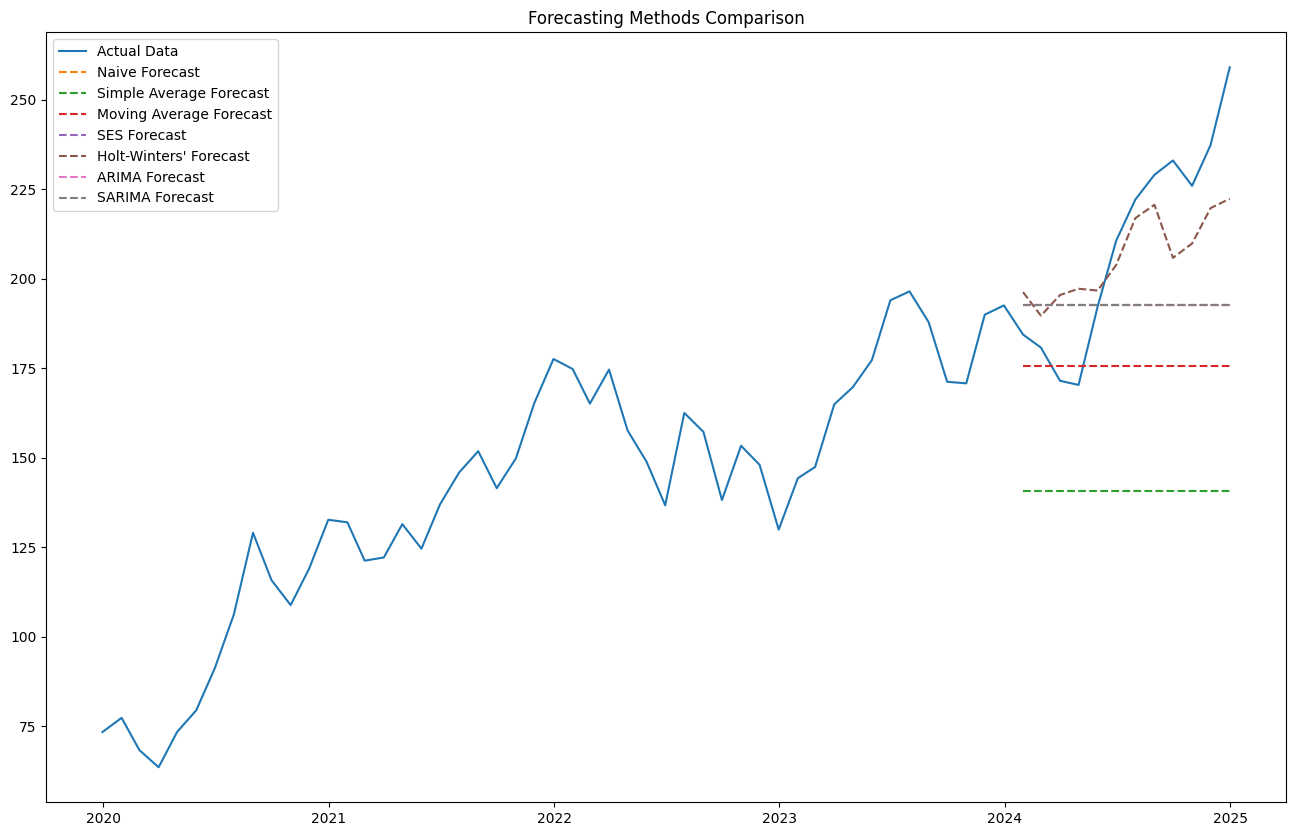

In [17]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
# 2. Split data into training and testing sets
train_data = monthly_appdatats[:-12]  # Use all but the last 12 months for training
test_data = monthly_appdatats[-12:]  # Use the last 12 months for testing

# 3. Forecasting Methods

# a) Naive Method
naive_forecast = [train_data[-1]] * len(test_data)

# b) Simple Average Method
simple_avg_forecast = [np.mean(train_data)] * len(test_data)

# c) Moving Average Method (using a window of 3 months as an example)
window = 12
moving_avg = train_data.rolling(window=window).mean()
moving_avg_forecast = [moving_avg[-1]] * len(test_data)

# d) Exponential Smoothing Methods
# Simple Exponential Smoothing (SES)
ses_model = SimpleExpSmoothing(train_data).fit()
ses_forecast = ses_model.forecast(len(test_data))

# Holt-Winters' Exponential Smoothing (Double or Triple depending on seasonality)
#Check if there is seasonality using the previous code
from statsmodels.tsa.seasonal import seasonal_decompose
period = 12
decomposition = seasonal_decompose(monthly_appdatats, model='additive', period=period, extrapolate_trend='freq')
seasonal_component = decomposition.seasonal
if any(seasonal_component):
    hw_model = ExponentialSmoothing(train_data, trend="add", seasonal="add", seasonal_periods=12).fit()
    hw_forecast = hw_model.forecast(len(test_data))
else:
    hw_model = ExponentialSmoothing(train_data, trend="add").fit()
    hw_forecast = hw_model.forecast(len(test_data))

# e) ARIMA and SARIMA Models
# ARIMA (p, d, q) - Order of Autoregressive (AR), Differencing (I), and Moving Average (MA)
#Finding the optimal p, d, and q values
from pmdarima import auto_arima
stepwise_fit = auto_arima(train_data, trace=True, suppress_warnings=True)
p, d, q = stepwise_fit.order
arima_model = ARIMA(train_data, order=(p, d, q)).fit()
arima_forecast = arima_model.forecast(len(test_data))

# SARIMA (p, d, q)(P, D, Q)s - Seasonal ARIMA
#Finding the optimal P, D, and Q values
stepwise_fit_sarima = auto_arima(train_data, trace=True, suppress_warnings=True, seasonal=True, m=12)
p_sarima, d_sarima, q_sarima = stepwise_fit_sarima.order
P, D, Q, s = stepwise_fit_sarima.seasonal_order
sarima_model = SARIMAX(train_data, order=(p_sarima, d_sarima, q_sarima), seasonal_order=(P, D, Q, s)).fit()
sarima_forecast = sarima_model.forecast(len(test_data))

# 4. Evaluate the models
def evaluate_model(actual, forecast, model_name):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    return mae, rmse

evaluate_model(test_data, naive_forecast, "Naive")
evaluate_model(test_data, simple_avg_forecast, "Simple Average")
evaluate_model(test_data, moving_avg_forecast, "Moving Average")
evaluate_model(test_data, ses_forecast, "Simple Exponential Smoothing")
evaluate_model(test_data, hw_forecast, "Holt-Winters'")
evaluate_model(test_data, arima_forecast, "ARIMA")
evaluate_model(test_data, sarima_forecast, "SARIMA")

# 5. Plot the forecasts
plt.figure(figsize=(16, 10))
plt.plot(monthly_appdatats, label="Actual Data")
plt.plot(test_data.index, naive_forecast, label="Naive Forecast", linestyle="--")
plt.plot(test_data.index, simple_avg_forecast, label="Simple Average Forecast", linestyle="--")
plt.plot(test_data.index, moving_avg_forecast, label="Moving Average Forecast", linestyle="--")
plt.plot(test_data.index, ses_forecast, label="SES Forecast", linestyle="--")
plt.plot(test_data.index, hw_forecast, label="Holt-Winters' Forecast", linestyle="--")
plt.plot(test_data.index, arima_forecast, label="ARIMA Forecast", linestyle="--")
plt.plot(test_data.index, sarima_forecast, label="SARIMA Forecast", linestyle="--")
plt.legend()
plt.title("Forecasting Methods Comparison")
plt.show()

In [18]:
pd.options.display.max_rows = 9999


# Load the data
appdata = pd.read_csv('/kaggle/input/appl-data/Apple Inc. Common Stock.csv')

# Select the 'Close Price' column and convert it to a time series
appdata['Date'] = pd.to_datetime(appdata['Date'])
ts = appdata.set_index('Date')['Close/Last']

# Resample to monthly frequency if needed
ts = ts.resample('M').last() 

print(ts.head(50))

Date
2024-11-30    $237.33
2024-12-31    $259.02
Freq: M, Name: Close/Last, dtype: object


In [19]:
print(appdata.head(10))

        Date Close/Last     Volume      Open       High        Low
0 2024-12-26    $259.02   27262980   $258.19    $260.10    $257.63
1 2024-12-24    $258.20   23234710   $255.49    $258.21    $255.29
2 2024-12-23    $255.27   40858770   $254.77    $255.65    $253.45
3 2024-12-20    $254.49  147495300   $248.04    $255.00    $245.69
4 2024-12-19    $249.79   60882260   $247.50    $252.00  $247.0949
5 2024-12-18    $248.05   56774100   $252.16    $254.28    $247.74
6 2024-12-17    $253.48   51356360   $250.08    $253.83    $249.78
7 2024-12-16    $251.04   51694750   $247.99    $251.38    $247.65
8 2024-12-13    $248.13   33155290  $247.815  $249.2902    $246.24
9 2024-12-12    $247.96   32777530   $246.89    $248.74    $245.68


In [20]:
print(appdata.head())

        Date Close/Last     Volume     Open     High        Low
0 2024-12-26    $259.02   27262980  $258.19  $260.10    $257.63
1 2024-12-24    $258.20   23234710  $255.49  $258.21    $255.29
2 2024-12-23    $255.27   40858770  $254.77  $255.65    $253.45
3 2024-12-20    $254.49  147495300  $248.04  $255.00    $245.69
4 2024-12-19    $249.79   60882260  $247.50  $252.00  $247.0949


In [21]:
print(appdata.tail()) 

         Date Close/Last    Volume      Open     High        Low
15 2024-12-04    $243.01  44383940   $242.87  $244.11    $241.25
16 2024-12-03    $242.65  38861020   $239.81  $242.76    $238.90
17 2024-12-02    $239.59  48137100   $237.27  $240.79    $237.16
18 2024-11-29    $237.33  28481380  $234.805  $237.81    $233.97
19 2024-11-27    $234.93  33498440  $234.465  $235.69  $233.8101


In [22]:
print(appdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        20 non-null     datetime64[ns]
 1   Close/Last  20 non-null     object        
 2   Volume      20 non-null     int64         
 3   Open        20 non-null     object        
 4   High        20 non-null     object        
 5   Low         20 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.1+ KB
None


Data Cleaning 
Removing the empty cell values 

In [23]:
new_appdata = appdata.dropna()

print(new_appdata.to_string())

         Date Close/Last     Volume      Open       High        Low
0  2024-12-26    $259.02   27262980   $258.19    $260.10    $257.63
1  2024-12-24    $258.20   23234710   $255.49    $258.21    $255.29
2  2024-12-23    $255.27   40858770   $254.77    $255.65    $253.45
3  2024-12-20    $254.49  147495300   $248.04    $255.00    $245.69
4  2024-12-19    $249.79   60882260   $247.50    $252.00  $247.0949
5  2024-12-18    $248.05   56774100   $252.16    $254.28    $247.74
6  2024-12-17    $253.48   51356360   $250.08    $253.83    $249.78
7  2024-12-16    $251.04   51694750   $247.99    $251.38    $247.65
8  2024-12-13    $248.13   33155290  $247.815  $249.2902    $246.24
9  2024-12-12    $247.96   32777530   $246.89    $248.74    $245.68
10 2024-12-11    $246.49   45205810   $247.96    $250.80  $246.2601
11 2024-12-10    $247.77   36914810   $246.89    $248.21    $245.34
12 2024-12-09    $246.75   44649230   $241.83    $247.24    $241.75
13 2024-12-06    $242.84   36870620  $242.905   

In [24]:
print(new_appdata)

         Date Close/Last     Volume      Open       High        Low
0  2024-12-26    $259.02   27262980   $258.19    $260.10    $257.63
1  2024-12-24    $258.20   23234710   $255.49    $258.21    $255.29
2  2024-12-23    $255.27   40858770   $254.77    $255.65    $253.45
3  2024-12-20    $254.49  147495300   $248.04    $255.00    $245.69
4  2024-12-19    $249.79   60882260   $247.50    $252.00  $247.0949
5  2024-12-18    $248.05   56774100   $252.16    $254.28    $247.74
6  2024-12-17    $253.48   51356360   $250.08    $253.83    $249.78
7  2024-12-16    $251.04   51694750   $247.99    $251.38    $247.65
8  2024-12-13    $248.13   33155290  $247.815  $249.2902    $246.24
9  2024-12-12    $247.96   32777530   $246.89    $248.74    $245.68
10 2024-12-11    $246.49   45205810   $247.96    $250.80  $246.2601
11 2024-12-10    $247.77   36914810   $246.89    $248.21    $245.34
12 2024-12-09    $246.75   44649230   $241.83    $247.24    $241.75
13 2024-12-06    $242.84   36870620  $242.905   

In [25]:
appdata['Date'] = pd.to_datetime(appdata['Date'])

print(appdata.to_string())

         Date Close/Last     Volume      Open       High        Low
0  2024-12-26    $259.02   27262980   $258.19    $260.10    $257.63
1  2024-12-24    $258.20   23234710   $255.49    $258.21    $255.29
2  2024-12-23    $255.27   40858770   $254.77    $255.65    $253.45
3  2024-12-20    $254.49  147495300   $248.04    $255.00    $245.69
4  2024-12-19    $249.79   60882260   $247.50    $252.00  $247.0949
5  2024-12-18    $248.05   56774100   $252.16    $254.28    $247.74
6  2024-12-17    $253.48   51356360   $250.08    $253.83    $249.78
7  2024-12-16    $251.04   51694750   $247.99    $251.38    $247.65
8  2024-12-13    $248.13   33155290  $247.815  $249.2902    $246.24
9  2024-12-12    $247.96   32777530   $246.89    $248.74    $245.68
10 2024-12-11    $246.49   45205810   $247.96    $250.80  $246.2601
11 2024-12-10    $247.77   36914810   $246.89    $248.21    $245.34
12 2024-12-09    $246.75   44649230   $241.83    $247.24    $241.75
13 2024-12-06    $242.84   36870620  $242.905   

In [26]:
print(appdata)

         Date Close/Last     Volume      Open       High        Low
0  2024-12-26    $259.02   27262980   $258.19    $260.10    $257.63
1  2024-12-24    $258.20   23234710   $255.49    $258.21    $255.29
2  2024-12-23    $255.27   40858770   $254.77    $255.65    $253.45
3  2024-12-20    $254.49  147495300   $248.04    $255.00    $245.69
4  2024-12-19    $249.79   60882260   $247.50    $252.00  $247.0949
5  2024-12-18    $248.05   56774100   $252.16    $254.28    $247.74
6  2024-12-17    $253.48   51356360   $250.08    $253.83    $249.78
7  2024-12-16    $251.04   51694750   $247.99    $251.38    $247.65
8  2024-12-13    $248.13   33155290  $247.815  $249.2902    $246.24
9  2024-12-12    $247.96   32777530   $246.89    $248.74    $245.68
10 2024-12-11    $246.49   45205810   $247.96    $250.80  $246.2601
11 2024-12-10    $247.77   36914810   $246.89    $248.21    $245.34
12 2024-12-09    $246.75   44649230   $241.83    $247.24    $241.75
13 2024-12-06    $242.84   36870620  $242.905   

In [27]:
print(appdata.duplicated())

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
dtype: bool


In [28]:
appdata.head(), appdata.describe()

(        Date Close/Last     Volume     Open     High        Low
 0 2024-12-26    $259.02   27262980  $258.19  $260.10    $257.63
 1 2024-12-24    $258.20   23234710  $255.49  $258.21    $255.29
 2 2024-12-23    $255.27   40858770  $254.77  $255.65    $253.45
 3 2024-12-20    $254.49  147495300  $248.04  $255.00    $245.69
 4 2024-12-19    $249.79   60882260  $247.50  $252.00  $247.0949,
                       Date        Volume
 count                   20  2.000000e+01
 mean   2024-12-11 16:48:00  4.612641e+07
 min    2024-11-27 00:00:00  2.323471e+07
 25%    2024-12-04 18:00:00  3.341265e+07
 50%    2024-12-11 12:00:00  4.044632e+07
 75%    2024-12-18 06:00:00  4.894192e+07
 max    2024-12-26 00:00:00  1.474953e+08
 std                    NaN  2.581362e+07)

In [29]:
# Remove dollar signs and convert to float 

appdata['Close/Last'] = appdata['Close/Last'].replace('[\$,]', '', regex=True).astype(float) 
appdata['Open'] = appdata['Open'].replace('[\$,]', '', regex=True).astype(float)
appdata['High'] = appdata['High'].replace('[\$,]', '', regex=True).astype(float)
appdata['Low'] = appdata['Low'].replace('[\$,]', '', regex=True).astype(float)

In [30]:
# Displaying the cleaned dataset for verification
appdata.head(), appdata.describe()

(        Date  Close/Last     Volume    Open    High       Low
 0 2024-12-26      259.02   27262980  258.19  260.10  257.6300
 1 2024-12-24      258.20   23234710  255.49  258.21  255.2900
 2 2024-12-23      255.27   40858770  254.77  255.65  253.4500
 3 2024-12-20      254.49  147495300  248.04  255.00  245.6900
 4 2024-12-19      249.79   60882260  247.50  252.00  247.0949,
                       Date  Close/Last        Volume        Open        High  \
 count                   20   20.000000  2.000000e+01   20.000000   20.000000   
 mean   2024-12-11 16:48:00  247.491500  4.612641e+07  246.086000  248.753010   
 min    2024-11-27 00:00:00  234.930000  2.323471e+07  234.465000  235.690000   
 25%    2024-12-04 18:00:00  242.967500  3.341265e+07  242.610000  244.432500   
 50%    2024-12-11 12:00:00  247.865000  4.044632e+07  247.195000  249.015100   
 75%    2024-12-18 06:00:00  251.650000  4.894192e+07  248.550000  253.942500   
 max    2024-12-26 00:00:00  259.020000  1.474953e+08 

In [31]:
appdata['Date'] = pd.to_datetime(appdata['Date'])  # Convert 'Date' to datetime
appdata.set_index('Date', inplace=True)  # Set 'Date' as the index
appdata.sort_index(inplace=True)  # Ensure the data is sorted by date

# Displaying the cleaned dataset for verification
appdata.head(), appdata.describe()

(            Close/Last    Volume     Open    High       Low
 Date                                                       
 2024-11-27      234.93  33498440  234.465  235.69  233.8101
 2024-11-29      237.33  28481380  234.805  237.81  233.9700
 2024-12-02      239.59  48137100  237.270  240.79  237.1600
 2024-12-03      242.65  38861020  239.810  242.76  238.9000
 2024-12-04      243.01  44383940  242.870  244.11  241.2500,
        Close/Last        Volume        Open        High         Low
 count   20.000000  2.000000e+01   20.000000   20.000000   20.000000
 mean   247.491500  4.612641e+07  246.086000  248.753010  244.944755
 std      6.576778  2.581362e+07    6.500296    6.615915    6.364489
 min    234.930000  2.323471e+07  234.465000  235.690000  233.810100
 25%    242.967500  3.341265e+07  242.610000  244.432500  241.625000
 50%    247.865000  4.044632e+07  247.195000  249.015100  245.685000
 75%    251.650000  4.894192e+07  248.550000  253.942500  247.672500
 max    259.020000  

In [32]:
appdata.corr()

,Close/Last,Volume,Open,High,Low
Close/Last,1.000000,0.222253,0.936833,0.973669,0.956078
Volume,0.222253,1.000000,0.066262,0.237420,0.013568
Open,0.936833,0.066262,1.000000,0.969916,0.987851
High,0.973669,0.237420,0.969916,1.000000,0.964667
Low,0.956078,0.013568,0.987851,0.964667,1.000000


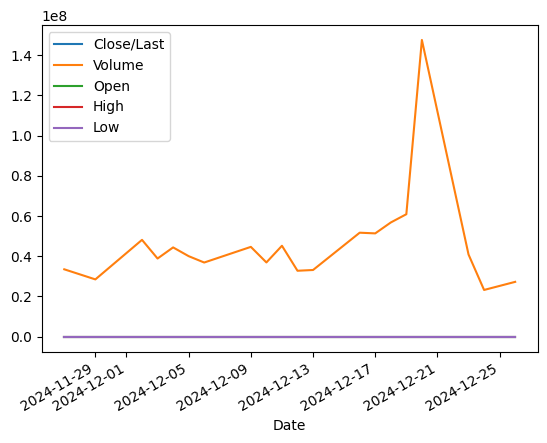

In [33]:
import sys
import matplotlib


import pandas as pd
import matplotlib.pyplot as plt

# Plot the time series
appdata.plot()

plt.show()




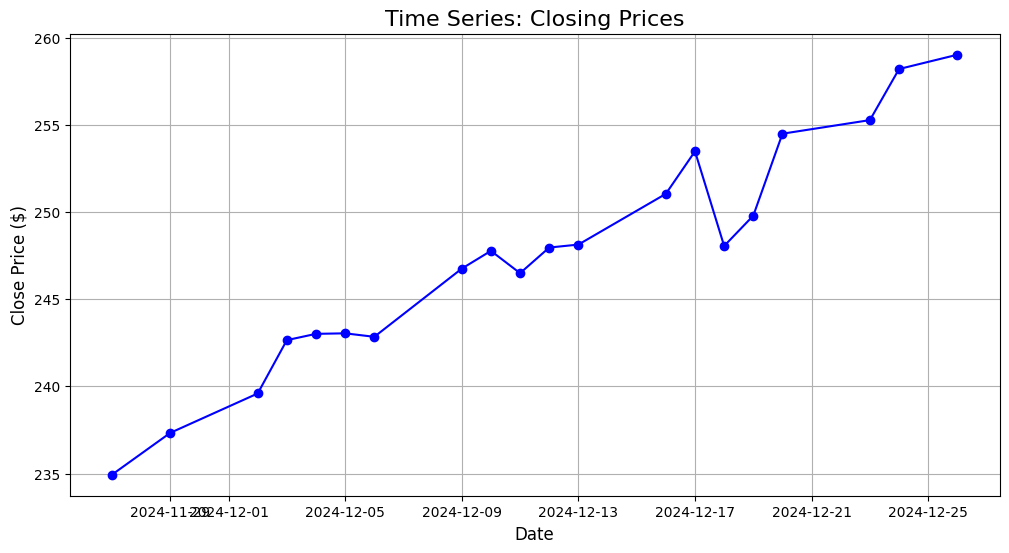

In [34]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(appdata.index, appdata['Close/Last'], marker='o', linestyle='-', color='blue')
plt.title('Time Series: Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price ($)', fontsize=12)
plt.grid(True)
plt.show()

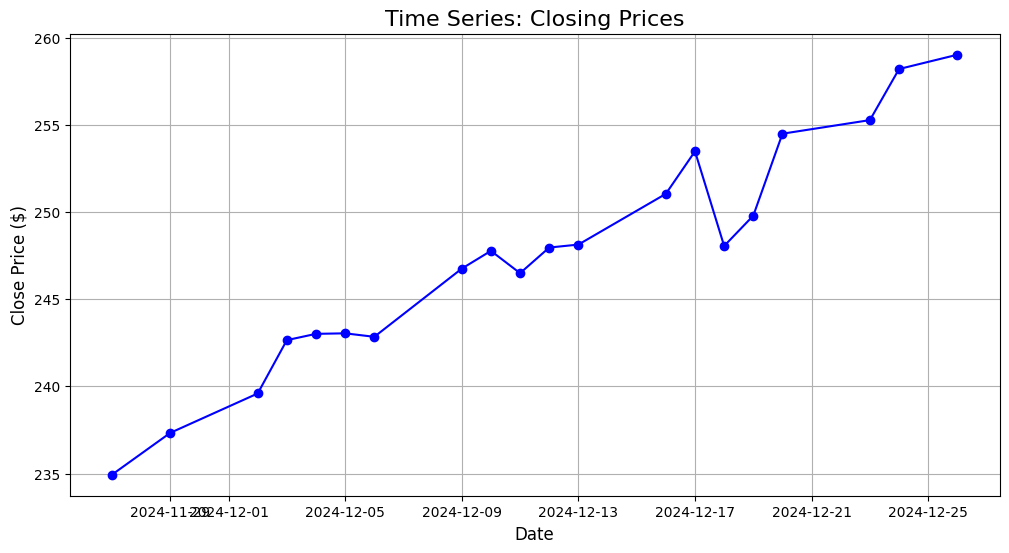

In [35]:
import matplotlib.pyplot as plt

# If you're using Jupyter Notebook, uncomment the following line
# %matplotlib inline

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(appdata.index, appdata['Close/Last'], marker='o', linestyle='-', color='blue')
plt.title('Time Series: Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price ($)', fontsize=12)
plt.grid(True)
plt.show()


In [36]:
import pandas as pd

# Load the data
appdata = pd.read_csv("/kaggle/input/historicaldata/HistoricalData_AAPL  Historical Quotes.csv")

# Select the 'Close Price' column and convert it to a time series
appdata['Close/Last'] = appdata['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
appdata['Date'] = pd.to_datetime(appdata['Date'])
monthly_appdatats = appdata.set_index('Date')['Close/Last']

# Resample to monthly frequency if needed
monthly_appdatats = monthly_appdatats.resample('M').last() 
# Displaying the cleaned dataset for verification
monthly_appdatats.head(), monthly_appdatats.describe()

(Date
 2019-12-31    73.4125
 2020-01-31    77.3775
 2020-02-29    68.3400
 2020-03-31    63.5725
 2020-04-30    73.4500
 Freq: M, Name: Close/Last, dtype: float64,
 count     61.00000
 mean     154.23291
 std       43.74819
 min       63.57250
 25%      129.93000
 50%      153.34000
 75%      177.57000
 max      259.02000
 Name: Close/Last, dtype: float64)

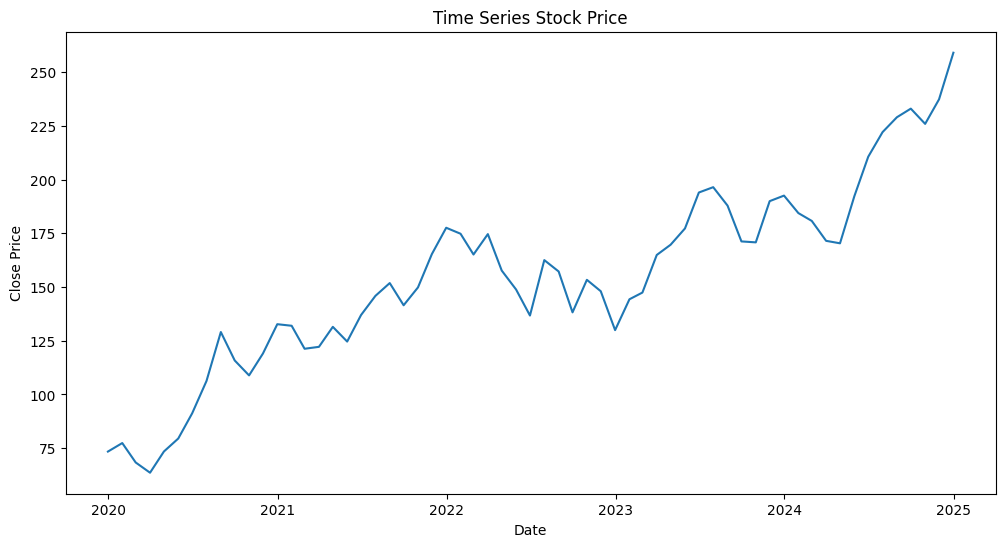

<function matplotlib.pyplot.show(close=None, block=None)>

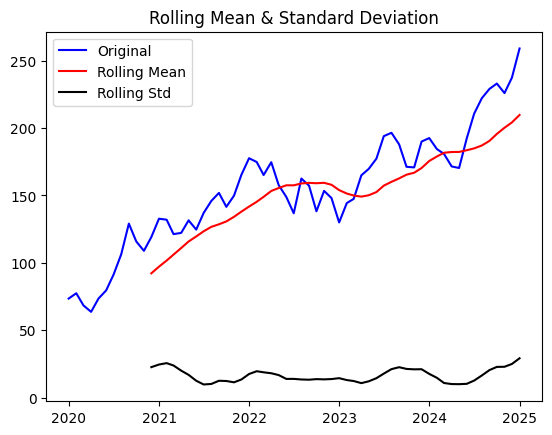

In [37]:
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(monthly_appdatats)
plt.title("Time Series Stock Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

# Calculate and plot rolling statistics
rolmean = monthly_appdatats.rolling(window=12).mean()
rolstd = monthly_appdatats.rolling(window=12).std()
plt.plot(monthly_appdatats, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show



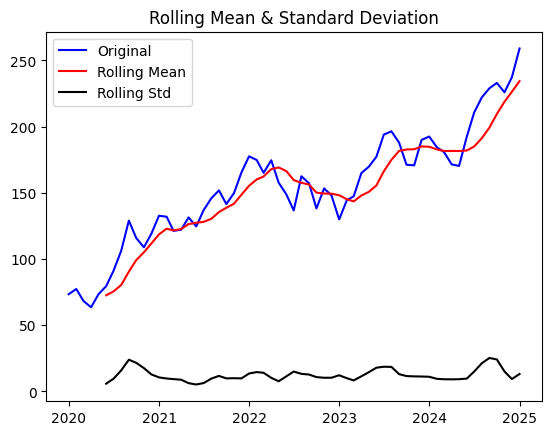

In [38]:
# Calculate and plot rolling statistics
rolmean = monthly_appdatats.rolling(window=6).mean()
rolstd = monthly_appdatats.rolling(window=6).std()
plt.plot(monthly_appdatats, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

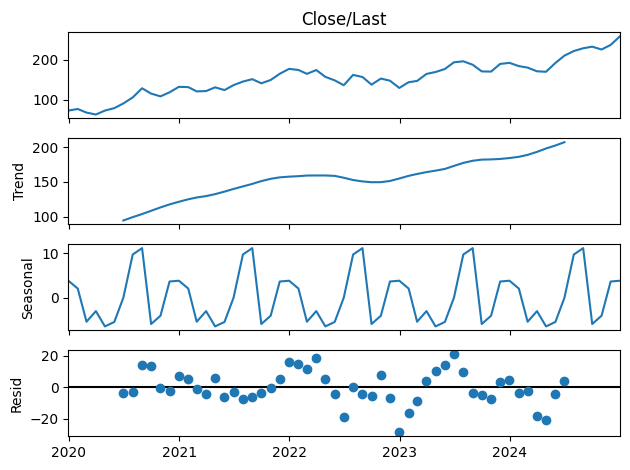

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(monthly_appdatats, model='additive', period=12) 

# Plot the decomposed time series
decomposition.plot()
plt.show()

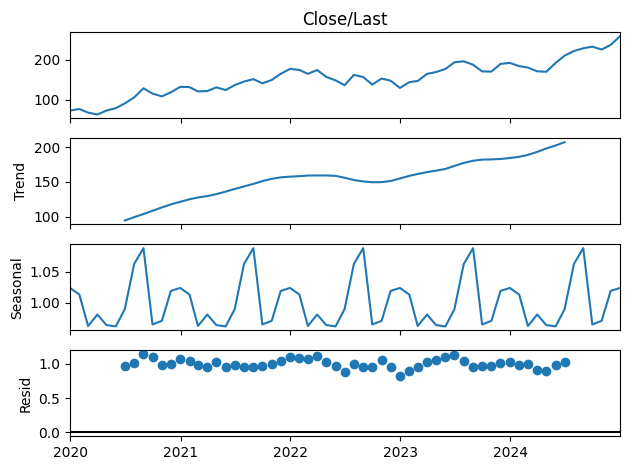

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(monthly_appdatats, model='multiplecative', period=12) 

# Plot the decomposed time series
decomposition.plot()
plt.show()

<ipython-input-41-91cd785b7353>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  naive_forecast = [train_data[-1]] * len(test_data)
<ipython-input-41-91cd785b7353>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  moving_avg_forecast = [moving_avg[-1]] * len(test_data)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=375.035, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=377.033, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=377.032, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=375.204, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=378.134, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.274 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=376.379, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=375.035, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=377.543, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=377.633, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=375.204, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=375.564, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=375.668, Tim

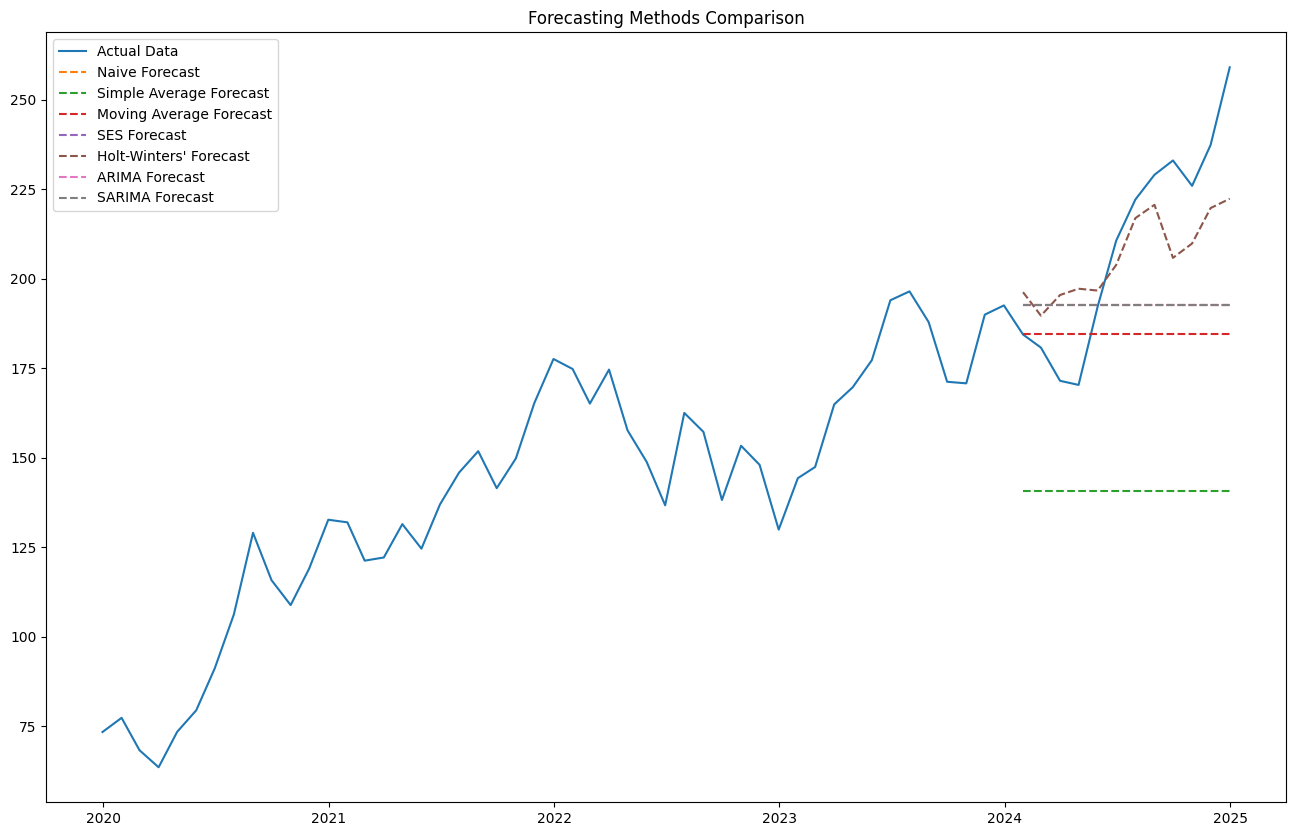

In [41]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 2. Split data into training and testing sets
train_data = monthly_appdatats[:-12]  # Use all but the last 12 months for training
test_data = monthly_appdatats[-12:]  # Use the last 12 months for testing

# 3. Forecasting Methods

# a) Naive Method
naive_forecast = [train_data[-1]] * len(test_data)

# b) Simple Average Method
simple_avg_forecast = [np.mean(train_data)] * len(test_data)

# c) Moving Average Method (using a window of 3 months as an example)
window = 3
moving_avg = train_data.rolling(window=window).mean()
moving_avg_forecast = [moving_avg[-1]] * len(test_data)

# d) Exponential Smoothing Methods
# Simple Exponential Smoothing (SES)
ses_model = SimpleExpSmoothing(train_data).fit()
ses_forecast = ses_model.forecast(len(test_data))

# Holt-Winters' Exponential Smoothing (Double or Triple depending on seasonality)
#Check if there is seasonality using the previous code
from statsmodels.tsa.seasonal import seasonal_decompose
period = 12
decomposition = seasonal_decompose(monthly_appdatats, model='additive', period=period, extrapolate_trend='freq')
seasonal_component = decomposition.seasonal
if any(seasonal_component):
    hw_model = ExponentialSmoothing(train_data, trend="add", seasonal="add", seasonal_periods=12).fit()
    hw_forecast = hw_model.forecast(len(test_data))
else:
    hw_model = ExponentialSmoothing(train_data, trend="add").fit()
    hw_forecast = hw_model.forecast(len(test_data))

# e) ARIMA and SARIMA Models
# ARIMA (p, d, q) - Order of Autoregressive (AR), Differencing (I), and Moving Average (MA)
#Finding the optimal p, d, and q values
from pmdarima import auto_arima
stepwise_fit = auto_arima(train_data, trace=True, suppress_warnings=True)
p, d, q = stepwise_fit.order
arima_model = ARIMA(train_data, order=(p, d, q)).fit()
arima_forecast = arima_model.forecast(len(test_data))

# SARIMA (p, d, q)(P, D, Q)s - Seasonal ARIMA
#Finding the optimal P, D, and Q values
stepwise_fit_sarima = auto_arima(train_data, trace=True, suppress_warnings=True, seasonal=True, m=12)
p_sarima, d_sarima, q_sarima = stepwise_fit_sarima.order
P, D, Q, s = stepwise_fit_sarima.seasonal_order
sarima_model = SARIMAX(train_data, order=(p_sarima, d_sarima, q_sarima), seasonal_order=(P, D, Q, s)).fit()
sarima_forecast = sarima_model.forecast(len(test_data))

# 4. Evaluate the models
def evaluate_model(actual, forecast, model_name):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    return mae, rmse

evaluate_model(test_data, naive_forecast, "Naive")
evaluate_model(test_data, simple_avg_forecast, "Simple Average")
evaluate_model(test_data, moving_avg_forecast, "Moving Average")
evaluate_model(test_data, ses_forecast, "Simple Exponential Smoothing")
evaluate_model(test_data, hw_forecast, "Holt-Winters'")
evaluate_model(test_data, arima_forecast, "ARIMA")
evaluate_model(test_data, sarima_forecast, "SARIMA")

# 5. Plot the forecasts
plt.figure(figsize=(16, 10))
plt.plot(monthly_appdatats, label="Actual Data")
plt.plot(test_data.index, naive_forecast, label="Naive Forecast", linestyle="--")
plt.plot(test_data.index, simple_avg_forecast, label="Simple Average Forecast", linestyle="--")
plt.plot(test_data.index, moving_avg_forecast, label="Moving Average Forecast", linestyle="--")
plt.plot(test_data.index, ses_forecast, label="SES Forecast", linestyle="--")
plt.plot(test_data.index, hw_forecast, label="Holt-Winters' Forecast", linestyle="--")
plt.plot(test_data.index, arima_forecast, label="ARIMA Forecast", linestyle="--")
plt.plot(test_data.index, sarima_forecast, label="SARIMA Forecast", linestyle="--")
plt.legend()
plt.title("Forecasting Methods Comparison")
plt.show()

In [42]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 2. Split data into training and testing sets
train_monthly_appdatats = monthly_appdatats[:-12]  # Use all but the last 12 months for training
test_monthly_appdatats = monthly_appdatats[-12:]  # Use the last 12 months for testing


# --- ARIMA Modeling ---
print("\n--- ARIMA Modeling ---")


--- ARIMA Modeling ---


In [43]:
# a) Stationarity Check (Dickey-Fuller Test)
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result[1]

print("Original Series:")
p_value = adf_test(train_monthly_appdatats)

Original Series:
ADF Statistic: -1.505611
p-value: 0.530734
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600


In [44]:
# Differencing if necessary
d = 0
while p_value > 0.05:
    train_monthly_appdatats = train_monthly_appdatats.diff().dropna()
    d += 1
    print(f"\nDifferencing (d={d}):")
    p_value = adf_test(train_monthly_appdatats)
print(f"Series is stationary after {d} differencing(s).")


Differencing (d=1):
ADF Statistic: -6.120180
p-value: 0.000000
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602
Series is stationary after 1 differencing(s).


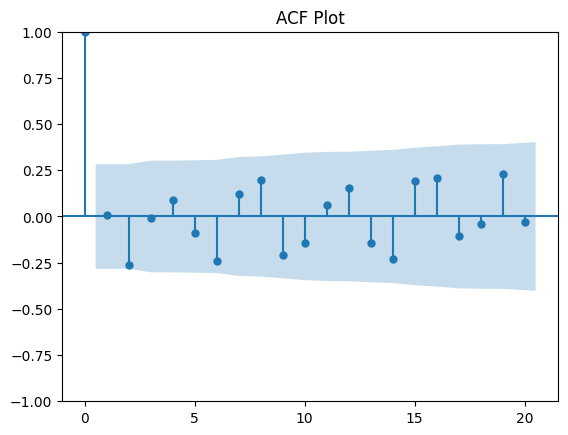

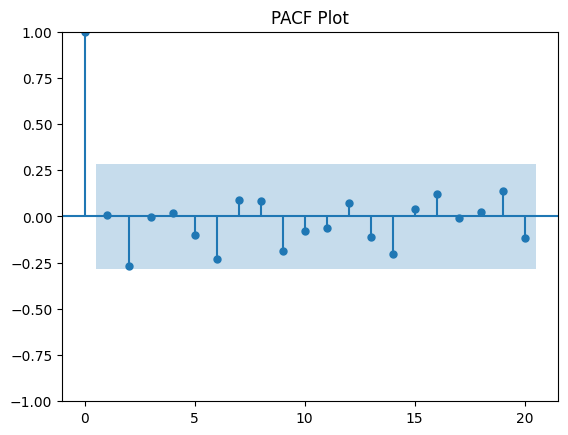

In [45]:
# b) ACF and PACF Plots
plot_acf(train_monthly_appdatats, lags=20)
plt.title("ACF Plot")
plt.show()
plot_pacf(train_monthly_appdatats, lags=20)
plt.title("PACF Plot")
plt.show()

In [46]:
# Based on ACF and PACF, choose p and q (example: p=1, q=1)
p = 0
q = 1

# Build and fit the ARIMA model
arima_model = ARIMA(train_monthly_appdatats, order=(p, d, q)).fit()

# c) Model Summary
print("\nARIMA Model Summary:")
print(arima_model.summary())


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Close/Last   No. Observations:                   48
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -184.083
Date:                Wed, 19 Feb 2025   AIC                            372.166
Time:                        00:32:50   BIC                            375.867
Sample:                    01-31-2020   HQIC                           373.559
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9988      2.918     -0.342      0.732      -6.717       4.719
sigma2       136.2060    394.992      0.345      0.730    -637.964     910.376
Ljung-Box (L1) (Q):           

In [47]:
# d) ARIMA Forecast
arima_forecast = arima_model.forecast(steps=len(test_monthly_appdatats))



In [48]:
# a) Stationarity Check (Dickey-Fuller Test)
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result[1]

print("Original Series:")
p_value = adf_test(train_monthly_appdatats)

# Differencing if necessary
d = 0
while p_value > 0.05:
    train_monthly_appdatats = train_monthly_appdatats.diff().dropna()
    d += 1
    print(f"\nDifferencing (d={d}):")
    p_value = adf_test(train_monthly_appdatats)
print(f"Series is stationary after {d} differencing(s).")

Original Series:
ADF Statistic: -6.120180
p-value: 0.000000
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602
Series is stationary after 0 differencing(s).


In [49]:
from statsmodels.tsa.stattools import adfuller

# Dickey-Fuller Test
def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

# Original Series
print("Original Series:")
check_stationarity(monthly_appdatats)

# First Differencing
monthly_appdata_diff1 = monthly_appdatats.diff().dropna()
print("\nAfter First Differencing:")
check_stationarity(monthly_appdata_diff1)

# Second Differencing (if needed)
monthly_appdata_diff2 = monthly_appdata_diff1.diff().dropna()
if not monthly_appdata_diff1.empty:
    print("\nAfter Second Differencing:")
    check_stationarity(monthly_appdata_diff2)


Original Series:
ADF Statistic: -0.4551260943001907
p-value: 0.9004798973152014
The series is NOT stationary.

After First Differencing:
ADF Statistic: -6.441336015044945
p-value: 1.6053426528646926e-08
The series is stationary.

After Second Differencing:
ADF Statistic: -6.234896499760531
p-value: 4.8524015299975646e-08
The series is stationary.
